# 02 - NFL Feature Engineering for Moneyline Prediction

**Goal**: Create sophisticated features for NFL moneyline prediction using research-backed approaches

**Objective**: Build a comprehensive feature set that captures:
- EPA-based team performance metrics (most predictive)
- Dynamic rolling averages with smart windowing
- Team-specific home field advantages
- Schedule and environmental factors
- Opponent strength adjustments

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nflreadpy as nfl
import pyarrow as pa

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Load multiple seasons of data for robust feature engineering
seasons = [2020, 2021, 2022, 2023, 2024]

# Load schedules with betting lines and game context
schedules = nfl.load_schedules(seasons)
games_df = schedules.to_pandas()

# Load play-by-play for EPA-based features (core predictor)
pbp_data = nfl.load_pbp(seasons)
pbp_df = pbp_data.to_pandas()

# Load team statistics for additional context
team_stats = nfl.load_team_stats(seasons)
team_stats_df = team_stats.to_pandas()

print(f"Data loaded - Games: {len(games_df)}, Plays: {len(pbp_df):,}, Team stats: {len(team_stats_df)}")

# Filter to regular season games only for model training
reg_games = games_df[games_df['game_type'] == 'REG'].copy()

# Convert dates for time-based features
reg_games['gameday'] = pd.to_datetime(reg_games['gameday'])
reg_games = reg_games.sort_values(['season', 'week', 'gameday']).reset_index(drop=True)

print(f"Regular season games: {len(reg_games)} | Seasons: {sorted(reg_games['season'].unique())}")

Loading Multi-Season NFL Data for Feature Engineering
Games loaded: 1408 (2020-09-10 to 2025-02-09)
Plays loaded: 246,218
Team stat records: 2816
Regular season games: 1343
Date range: 2020-09-10 00:00:00 to 2025-01-05 00:00:00
Seasons: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


## Feature Engineering 1: EPA-Based Features

**Research Finding**: EPA (Expected Points Added) features are the strongest predictors of NFL outcomes. We'll create 8 core EPA features: Home/Away × Offense/Defense × Pass/Rush EPA per play.

In [ ]:
# EPA features split by offense/defense × pass/rush as per research
def calculate_team_epa_features(pbp_df):
    """
    Calculate the 8 core EPA features that research shows are most predictive:
    Home/Away x Offense/Defense x Pass/Rush EPA per play
    """
    
    # Filter to actual plays with EPA
    plays = pbp_df[(~pbp_df['epa'].isna()) & (~pbp_df['posteam'].isna())].copy()
    
    # Separate passing and rushing plays
    pass_plays = plays[plays['play_type'] == 'pass'].copy()
    rush_plays = plays[plays['play_type'] == 'run'].copy()
    
    # Team offensive EPA features
    team_off_pass_epa = pass_plays.groupby(['game_id', 'posteam'])['epa'].mean().reset_index()
    team_off_pass_epa.columns = ['game_id', 'team', 'off_pass_epa']
    
    team_off_rush_epa = rush_plays.groupby(['game_id', 'posteam'])['epa'].mean().reset_index()
    team_off_rush_epa.columns = ['game_id', 'team', 'off_rush_epa']
    
    # Team defensive EPA features (opponent perspective, flipped sign)
    team_def_pass_epa = pass_plays.groupby(['game_id', 'defteam'])['epa'].mean().reset_index()
    team_def_pass_epa.columns = ['game_id', 'team', 'def_pass_epa']
    team_def_pass_epa['def_pass_epa'] = -team_def_pass_epa['def_pass_epa']  # Flip for defense
    
    team_def_rush_epa = rush_plays.groupby(['game_id', 'defteam'])['epa'].mean().reset_index()
    team_def_rush_epa.columns = ['game_id', 'team', 'def_rush_epa'] 
    team_def_rush_epa['def_rush_epa'] = -team_def_rush_epa['def_rush_epa']  # Flip for defense
    
    # Combine all EPA features
    epa_features = team_off_pass_epa.merge(team_off_rush_epa, on=['game_id', 'team'], how='outer')
    epa_features = epa_features.merge(team_def_pass_epa, on=['game_id', 'team'], how='outer')
    epa_features = epa_features.merge(team_def_rush_epa, on=['game_id', 'team'], how='outer')
    
    # Fill NAs with 0 for games where team didn't have pass/rush attempts
    epa_cols = ['off_pass_epa', 'off_rush_epa', 'def_pass_epa', 'def_rush_epa']
    epa_features[epa_cols] = epa_features[epa_cols].fillna(0)
    
    return epa_features

# Calculate EPA features for all games
team_epa_features = calculate_team_epa_features(pbp_df)

print(f"EPA features calculated for {len(team_epa_features)} team-games")

# Display sample EPA features
print("\nSample EPA Features:")
print(team_epa_features.head(10))

# Basic EPA feature statistics
epa_stats = team_epa_features[['off_pass_epa', 'off_rush_epa', 'def_pass_epa', 'def_rush_epa']].describe()
print(f"\nEPA Feature Statistics:")
print(epa_stats)

Engineering EPA-Based Features
Calculating EPA features for all seasons...
EPA features calculated for 2816 team-games
Feature columns: ['off_pass_epa', 'off_rush_epa', 'def_pass_epa', 'def_rush_epa']

Sample EPA Features:
           game_id team  off_pass_epa  off_rush_epa  def_pass_epa  \
0   2020_01_ARI_SF  ARI     -0.087195      0.267089     -0.010472   
1   2020_01_ARI_SF   SF      0.010472     -0.128386      0.087195   
2  2020_01_CHI_DET  CHI      0.067829      0.168876     -0.050269   
3  2020_01_CHI_DET  DET      0.050269     -0.104132     -0.067829   
4  2020_01_CLE_BAL  BAL      0.491451     -0.073323      0.259679   
5  2020_01_CLE_BAL  CLE     -0.259679     -0.222404     -0.491451   
6   2020_01_DAL_LA  DAL     -0.119773      0.135620     -0.154469   
7   2020_01_DAL_LA   LA      0.154469     -0.020802      0.119773   
8   2020_01_GB_MIN   GB      0.408363      0.184738     -0.246805   
9   2020_01_GB_MIN  MIN      0.246805      0.350095     -0.408363   

   def_rush_epa  

## Feature Engineering 2: Dynamic Rolling Averages

**Approach**: Use dynamic windows - 10-game window through week 10, full current-season data after week 10. This balances early-season sample size with late-season relevance.

In [ ]:
def calculate_rolling_averages(games_df, epa_features_df):
    
    # Merge EPA features with game data
    home_epa = epa_features_df.rename(columns={'team': 'home_team'})
    away_epa = epa_features_df.rename(columns={'team': 'away_team'})
    
    # Merge EPA features with games
    games_with_epa = games_df.merge(home_epa, on=['game_id', 'home_team'], how='left', suffixes=('', '_home'))
    games_with_epa = games_with_epa.merge(away_epa, on=['game_id', 'away_team'], how='left', suffixes=('', '_away'))
    
    # Create expanded dataset for rolling calculations
    rolling_features = []
    
    # Process each team and season
    for team in games_df['home_team'].unique():
        team_games = []
        
        # Collect all games for this team (home and away)
        home_games = games_with_epa[games_with_epa['home_team'] == team][
            ['game_id', 'season', 'week', 'gameday', 'home_team', 'away_team', 
             'home_score', 'away_score', 'off_pass_epa', 'off_rush_epa', 'def_pass_epa', 'def_rush_epa']
        ].copy()
        home_games['is_home'] = 1
        home_games.columns = ['game_id', 'season', 'week', 'gameday', 'team', 'opponent', 
                             'team_score', 'opp_score', 'off_pass_epa', 'off_rush_epa', 'def_pass_epa', 'def_rush_epa', 'is_home']
        
        away_games = games_with_epa[games_with_epa['away_team'] == team][
            ['game_id', 'season', 'week', 'gameday', 'away_team', 'home_team', 
             'away_score', 'home_score', 'off_pass_epa_away', 'off_rush_epa_away', 'def_pass_epa_away', 'def_rush_epa_away']
        ].copy()
        away_games['is_home'] = 0
        away_games.columns = ['game_id', 'season', 'week', 'gameday', 'team', 'opponent', 
                             'team_score', 'opp_score', 'off_pass_epa', 'off_rush_epa', 'def_pass_epa', 'def_rush_epa', 'is_home']
        
        # Combine home and away games
        team_games = pd.concat([home_games, away_games]).sort_values(['season', 'week']).reset_index(drop=True)
        team_games['team_win'] = (team_games['team_score'] > team_games['opp_score']).astype(int)
        team_games['point_diff'] = team_games['team_score'] - team_games['opp_score']
        
        # Calculate rolling averages
        for idx in range(len(team_games)):
            current_season = team_games.loc[idx, 'season']
            current_week = team_games.loc[idx, 'week']
            
            # Dynamic window logic
            if current_week <= 10:
                # Use 10-game window (including previous season)
                window_games = team_games.loc[:idx-1].tail(10) if idx > 0 else pd.DataFrame()
            else:
                # Use full current season
                current_season_games = team_games[
                    (team_games['season'] == current_season) & 
                    (team_games.index < idx)
                ]
                window_games = current_season_games
            
            # Calculate rolling features if we have data
            if len(window_games) > 0:
                team_games.loc[idx, 'roll_win_rate'] = window_games['team_win'].mean()
                team_games.loc[idx, 'roll_point_diff'] = window_games['point_diff'].mean()
                team_games.loc[idx, 'roll_off_pass_epa'] = window_games['off_pass_epa'].mean()
                team_games.loc[idx, 'roll_off_rush_epa'] = window_games['off_rush_epa'].mean()
                team_games.loc[idx, 'roll_def_pass_epa'] = window_games['def_pass_epa'].mean()
                team_games.loc[idx, 'roll_def_rush_epa'] = window_games['def_rush_epa'].mean()
                team_games.loc[idx, 'games_in_window'] = len(window_games)
            else:
                # No historical data - use neutral values
                team_games.loc[idx, 'roll_win_rate'] = 0.5
                team_games.loc[idx, 'roll_point_diff'] = 0.0
                team_games.loc[idx, 'roll_off_pass_epa'] = 0.0
                team_games.loc[idx, 'roll_off_rush_epa'] = 0.0
                team_games.loc[idx, 'roll_def_pass_epa'] = 0.0
                team_games.loc[idx, 'roll_def_rush_epa'] = 0.0
                team_games.loc[idx, 'games_in_window'] = 0
        
        rolling_features.append(team_games)
    
    return pd.concat(rolling_features, ignore_index=True)

sample_teams = ['KC', 'BUF', 'SF', 'PHI', 'DAL', 'BAL', 'MIA', 'CIN']  # Top teams
sample_games = reg_games[
    (reg_games['home_team'].isin(sample_teams)) | 
    (reg_games['away_team'].isin(sample_teams))
].copy()

rolling_data = calculate_rolling_averages(sample_games, team_epa_features)

print(f"Rolling features calculated for {len(rolling_data)} team-games")

# Display sample rolling features
rolling_sample = rolling_data[rolling_data['games_in_window'] > 0].head()
rolling_cols = ['team', 'season', 'week', 'roll_win_rate', 'roll_point_diff', 
                'roll_off_pass_epa', 'roll_def_pass_epa', 'games_in_window']
print("\nSample Rolling Features:")
print(rolling_sample[rolling_cols])

Creating Rolling Average Features with Dynamic Windows
Calculating rolling averages for all teams and seasons...
This may take 30-60 seconds...
Rolling features calculated for 1172 team-games
Sample size: count    1172.000000
mean        8.175768
std         4.163379
min         0.000000
25%         4.000000
50%        10.000000
75%        10.000000
max        16.000000
Name: games_in_window, dtype: float64

Sample Rolling Features:
  team  season  week  roll_win_rate  roll_point_diff  roll_off_pass_epa  \
1   KC    2020     2            1.0        14.000000           0.423874   
2   KC    2020     3            1.0         8.500000           0.249685   
3   KC    2020     4            1.0        10.333333           0.415487   
4   KC    2020     5            1.0        11.750000           0.327669   
5   KC    2020     6            0.8         7.800000           0.311060   

   roll_def_pass_epa  games_in_window  
1          -0.095079              1.0  
2          -0.087495            

## Feature Engineering 3: Team-Specific Home Field Advantage

**Research Finding**: Home field advantage varies significantly by team (2-6 point range). We'll calculate team-specific HFA adjusted for team strength.

In [ ]:
# Filter to completed games with scores
completed_games = reg_games[~reg_games['home_score'].isna()].copy()
completed_games['result'] = completed_games['home_score'] - completed_games['away_score']

# Calculate raw home field advantage by team
home_performance = completed_games.groupby('home_team').agg({
    'home_score': 'mean',
    'away_score': 'mean', 
    'result': lambda x: (x > 0).mean(),  # Home win rate
    'game_id': 'count'
}).rename(columns={'game_id': 'home_games', 'result': 'home_win_rate'})

home_performance['raw_hfa_points'] = home_performance['home_score'] - home_performance['away_score']

# Calculate away performance for comparison
away_performance = completed_games.groupby('away_team').agg({
    'away_score': 'mean',
    'home_score': 'mean',
    'result': lambda x: (x < 0).mean(),  # Away win rate  
    'game_id': 'count'
}).rename(columns={'game_id': 'away_games', 'result': 'away_win_rate'})

away_performance['away_point_diff'] = away_performance['away_score'] - away_performance['home_score']

# Combine home and away performance
team_hfa = home_performance.merge(away_performance, left_index=True, right_index=True, how='outer')

# Calculate adjusted HFA (accounting for team strength)
league_avg_hfa = completed_games['result'].mean()  # League average point differential


team_hfa['neutral_scoring'] = (team_hfa['home_score_x'] + team_hfa['away_score_y']) / 2
team_hfa['neutral_allowed'] = (team_hfa['away_score_x'] + team_hfa['home_score_y']) / 2
team_hfa['team_strength'] = team_hfa['neutral_scoring'] - team_hfa['neutral_allowed']

# Adjust HFA for team strength
team_hfa['adjusted_hfa'] = team_hfa['raw_hfa_points'] - (team_hfa['team_strength'] * 0.5)

# Identify dome vs outdoor teams (dome teams typically have lower HFA variance)
if 'roof' in completed_games.columns:
    roof_data = completed_games.groupby('home_team')['roof'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else 'unknown')
    team_hfa['primary_roof'] = roof_data

    # Apply variance adjustments based on venue type
    outdoor_teams = team_hfa[team_hfa['primary_roof'] == 'outdoors'].index
    if len(outdoor_teams) > 0:
        team_hfa.loc[outdoor_teams, 'hfa_variance'] = team_hfa.loc[outdoor_teams, 'adjusted_hfa'].std() * 1.2
        indoor_teams = team_hfa[~team_hfa.index.isin(outdoor_teams)].index
        if len(indoor_teams) > 0:
            team_hfa.loc[indoor_teams, 'hfa_variance'] = team_hfa.loc[indoor_teams, 'adjusted_hfa'].std() * 0.8

print(f"HFA calculated for {len(completed_games)} complete games")

# Display teams with highest and lowest HFA
hfa_display = team_hfa[['raw_hfa_points', 'adjusted_hfa', 'home_win_rate', 'home_games']].round(3)
if 'primary_roof' in team_hfa.columns:
    hfa_display['primary_roof'] = team_hfa['primary_roof']

print("Top 10 Home Field Advantages:")
print(hfa_display.sort_values('adjusted_hfa', ascending=False).head(10))

print("\nBottom 10 Home Field Advantages:")
print(hfa_display.sort_values('adjusted_hfa', ascending=True).head(10))

# HFA statistics by venue type
if 'primary_roof' in team_hfa.columns:
    print(f"\nHFA by Venue Type:")
    hfa_by_roof = team_hfa.groupby('primary_roof')['adjusted_hfa'].agg(['mean', 'std', 'count'])
    print(hfa_by_roof)

# League-wide HFA trend
league_hfa_by_season = completed_games.groupby('season')['result'].mean()
print(f"\nLeague HFA by Season (avg point differential):")
for season, hfa in league_hfa_by_season.items():
    print(f"  {season}: {hfa:.2f} points")

# Create HFA feature for modeling
print(f"\nHFA Summary: Mean={team_hfa['adjusted_hfa'].mean():.2f}, Range=[{team_hfa['adjusted_hfa'].min():.2f}, {team_hfa['adjusted_hfa'].max():.2f}], Teams={len(team_hfa)}")

Implementing Team-Specific Home Field Advantage
Processing 1343 complete games...
Step 1: Calculating home performance...
Step 2: Calculating away performance...
Step 3: Combining performance data...
Step 4: Calculating adjusted HFA...
Available columns after merge: ['home_score_x', 'away_score_x', 'home_win_rate', 'home_games', 'raw_hfa_points', 'away_score_y', 'home_score_y', 'away_win_rate', 'away_games', 'away_point_diff']
Step 5: Adding venue type information...
✅ HFA calculation complete!
Team-Specific Home Field Advantage:
Top 10 Home Field Advantages:
           raw_hfa_points  adjusted_hfa  home_win_rate  home_games  \
home_team                                                            
BUF                12.119         7.400          0.833          42   
MIA                 6.310         5.607          0.690          42   
GB                  7.524         5.304          0.738          42   
BAL                 8.167         4.863          0.643          42   
DAL           

## Feature Engineering 4: Schedule and Environmental Factors

**Research Findings**: 
- 3-6 day rest differentials: +1.2 points advantage
- Short week road games: -1.8 points disadvantage  
- Wind >20mph: -8% passing efficiency
- Extreme temperatures: -4 to -8 points scoring

In [ ]:
def calculate_schedule_factors(games_df):
    """
    Calculate rest days and weather impact features.
    Research shows:
    - 3-6 day rest differentials: +1.2 points advantage
    - Short week road games: -1.8 points disadvantage  
    - Wind >20mph: -8% passing efficiency
    - Temp <25°F or >85°F: -4 to -8 points scoring
    """
    
    schedule_features = games_df.copy()
    
    # Rest day calculations
    if 'home_rest' in schedule_features.columns and 'away_rest' in schedule_features.columns:
        schedule_features['home_rest'] = schedule_features['home_rest'].fillna(7)  # Default to 7 days
        schedule_features['away_rest'] = schedule_features['away_rest'].fillna(7)
        schedule_features['rest_differential'] = schedule_features['home_rest'] - schedule_features['away_rest']
        
        # Categorize rest advantages
        schedule_features['home_rest_advantage'] = 0
        schedule_features.loc[schedule_features['rest_differential'] >= 3, 'home_rest_advantage'] = 1.2
        schedule_features.loc[schedule_features['rest_differential'] <= -3, 'home_rest_advantage'] = -1.2
        
        # Short week penalties (≤4 days rest)
        schedule_features['home_short_week'] = (schedule_features['home_rest'] <= 4).astype(int)
        schedule_features['away_short_week'] = (schedule_features['away_rest'] <= 4).astype(int)
        schedule_features['away_short_week_road'] = schedule_features['away_short_week'] * (-1.8)
    else:
        # Default values if rest columns don't exist
        schedule_features['rest_differential'] = 0
        schedule_features['home_rest_advantage'] = 0
        schedule_features['away_short_week_road'] = 0
    
    # Weather impact features
    if 'temp' in schedule_features.columns:
        schedule_features['temp'] = schedule_features['temp'].fillna(70)  # Indoor/default temp
        
        # Extreme temperature penalties
        schedule_features['cold_weather'] = (schedule_features['temp'] < 25).astype(int) * (-4)
        schedule_features['hot_weather'] = (schedule_features['temp'] > 85).astype(int) * (-6)
        schedule_features['weather_impact'] = schedule_features['cold_weather'] + schedule_features['hot_weather']
    else:
        schedule_features['weather_impact'] = 0
        schedule_features['cold_weather'] = 0
        schedule_features['hot_weather'] = 0
    
    if 'wind' in schedule_features.columns:
        schedule_features['wind'] = schedule_features['wind'].fillna(0)  # Indoor/calm
        schedule_features['high_wind'] = (schedule_features['wind'] > 20).astype(int)
        schedule_features['wind_penalty'] = schedule_features['high_wind'] * (-0.08)  # 8% passing reduction
    else:
        schedule_features['high_wind'] = 0
        schedule_features['wind_penalty'] = 0
    
    # Dome game advantages (higher scoring, weather-neutral)
    if 'roof' in schedule_features.columns:
        schedule_features['dome_game'] = (schedule_features['roof'] == 'dome').astype(int)
        schedule_features['dome_scoring_boost'] = schedule_features['dome_game'] * 4  # +4 points avg
    else:
        schedule_features['dome_game'] = 0
        schedule_features['dome_scoring_boost'] = 0
    
    # Division game adjustments (familiarity reduces HFA)
    if 'div_game' in schedule_features.columns:
        schedule_features['div_game_hfa_reduction'] = schedule_features['div_game'] * (-1.5)
    else:
        schedule_features['div_game_hfa_reduction'] = 0
    
    # Week of season effects (early season uncertainty)
    schedule_features['early_season'] = (schedule_features['week'] <= 4).astype(int)
    schedule_features['late_season'] = (schedule_features['week'] >= 15).astype(int)
    
    return schedule_features

# Apply schedule factor calculations
schedule_data = calculate_schedule_factors(reg_games)

# Rest differential analysis
if 'rest_differential' in schedule_data.columns:
    print(f"Rest advantages - Home +3 days: {(schedule_data['rest_differential'] >= 3).sum()}, Away +3 days: {(schedule_data['rest_differential'] <= -3).sum()}")

# Weather impact analysis  
if 'temp' in schedule_data.columns:
    cold_games = (schedule_data['temp'] < 25).sum()
    hot_games = (schedule_data['temp'] > 85).sum()
    print(f"Weather - Cold games (<25°F): {cold_games}, Hot games (>85°F): {hot_games}")

if 'wind' in schedule_data.columns:
    high_wind = (schedule_data['wind'] > 20).sum()
    print(f"High wind games (>20mph): {high_wind}")

# Dome vs outdoor analysis
if 'roof' in schedule_data.columns:
    roof_counts = schedule_data['roof'].value_counts()
    print(f"Venue types: {dict(roof_counts)}")

# Division game impact
if 'div_game' in schedule_data.columns:
    div_games = schedule_data['div_game'].sum()
    print(f"Division games: {div_games} ({div_games/len(schedule_data)*100:.1f}%)")

# Show sample of schedule factors
schedule_feature_cols = ['game_id', 'home_team', 'away_team', 'week']
if 'rest_differential' in schedule_data.columns:
    schedule_feature_cols.extend(['rest_differential', 'home_rest_advantage'])
schedule_feature_cols.extend(['weather_impact', 'dome_scoring_boost'])
if 'div_game' in schedule_data.columns:
    schedule_feature_cols.append('div_game')

available_cols = [col for col in schedule_feature_cols if col in schedule_data.columns]

print(f"\nSample Schedule Features:")
print(schedule_data[available_cols].head(10))

Adding Schedule and Environmental Factors
Schedule Factor Analysis:
Rest Differential Statistics:
count    1343.000000
mean       -0.005957
std         2.408064
min        -8.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.000000
Name: rest_differential, dtype: float64

Games with significant rest advantages:
Home team +3 days: 142
Away team +3 days: 145

Weather Conditions:
Cold games (<25°F): 17
Hot games (>85°F): 21
Temperature range: 6.0°F to 93.0°F
High wind games (>20mph): 20
Wind range: 0.0 to 44.0 mph

Venue Types:
  outdoors: 882 games (65.7%)
  dome: 250 games (18.6%)
  closed: 179 games (13.3%)
  open: 32 games (2.4%)

Division Games: 480 (35.7%)

Sample Schedule Features:
           game_id home_team away_team  week  rest_differential  \
0   2020_01_HOU_KC        KC       HOU     1                  0   
1  2020_01_SEA_ATL       ATL       SEA     1                  0   
2  2020_01_CLE_BAL       BAL       CLE     1                  0   
3  

/var/folders/3v/pfcrcjlx7213t7bdd25088wr0000gn/T/ipykernel_94230/241132757.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  schedule_features.loc[schedule_features['rest_differential'] >= 3, 'home_rest_advantage'] = 1.2


## Feature Engineering 5: Opponent Strength Adjustments

**Approach**: Create opponent-strength adjusted metrics using projected win totals approach, which research shows outperforms traditional SOS calculations.

In [ ]:
def calculate_opponent_adjustments(games_df):
    """
    Create opponent-strength adjusted metrics using projected win totals approach.
    Research shows this outperforms traditional SOS calculations.
    """
    
    # Calculate season-level team strength ratings
    def get_team_strength_by_season(games_df):
        strength_ratings = {}
        
        for season in games_df['season'].unique():
            season_games = games_df[games_df['season'] == season].copy()
            season_games = season_games[~season_games['home_score'].isna()]  # Complete games only
            
            if len(season_games) == 0:
                continue
                
            # Calculate win percentage and point differential for each team
            team_records = {}
            
            for team in season_games['home_team'].unique():
                # Home games
                home_games = season_games[season_games['home_team'] == team]
                home_wins = (home_games['home_score'] > home_games['away_score']).sum()
                home_point_diff = (home_games['home_score'] - home_games['away_score']).sum()
                
                # Away games  
                away_games = season_games[season_games['away_team'] == team]
                away_wins = (away_games['away_score'] > away_games['home_score']).sum()
                away_point_diff = (away_games['away_score'] - away_games['home_score']).sum()
                
                total_games = len(home_games) + len(away_games)
                total_wins = home_wins + away_wins
                total_point_diff = home_point_diff + away_point_diff
                
                if total_games > 0:
                    team_records[team] = {
                        'win_pct': total_wins / total_games,
                        'avg_point_diff': total_point_diff / total_games,
                        'games': total_games
                    }
            
            # Convert to strength rating (combination of win% and point differential)
            for team, stats in team_records.items():
                # Normalize point differential to 0-1 scale and combine with win%
                strength_rating = (stats['win_pct'] * 0.6) + (min(max(stats['avg_point_diff'] + 14, 0), 28) / 28 * 0.4)
                team_records[team]['strength_rating'] = strength_rating
            
            strength_ratings[season] = team_records
        
        return strength_ratings
    
    # Get strength ratings
    strength_ratings = get_team_strength_by_season(games_df)
    
    # Create opponent-adjusted features
    opponent_adj_features = []
    
    for _, game in games_df.iterrows():
        game_features = {
            'game_id': game['game_id'],
            'season': game['season'], 
            'week': game['week'],
            'home_team': game['home_team'],
            'away_team': game['away_team']
        }
        
        season = game['season']
        home_team = game['home_team']
        away_team = game['away_team']
        
        # Get team strength ratings for this season
        if season in strength_ratings:
            home_strength = strength_ratings[season].get(home_team, {}).get('strength_rating', 0.5)
            away_strength = strength_ratings[season].get(away_team, {}).get('strength_rating', 0.5)
            
            game_features['home_team_strength'] = home_strength
            game_features['away_team_strength'] = away_strength
            game_features['strength_differential'] = home_strength - away_strength
            
            # Calculate opponent-adjusted EPA (if available)
            # Home team's offensive EPA adjusted for away team's defensive strength
            league_avg_def_strength = 0.5  # Neutral
            away_def_adjustment = league_avg_def_strength - away_strength
            home_def_adjustment = league_avg_def_strength - home_strength
            
            game_features['home_opp_adj_factor'] = 1 + away_def_adjustment
            game_features['away_opp_adj_factor'] = 1 + home_def_adjustment
        else:
            # Default neutral values
            game_features['home_team_strength'] = 0.5
            game_features['away_team_strength'] = 0.5  
            game_features['strength_differential'] = 0.0
            game_features['home_opp_adj_factor'] = 1.0
            game_features['away_opp_adj_factor'] = 1.0
        
        opponent_adj_features.append(game_features)
    
    return pd.DataFrame(opponent_adj_features)

# Calculate opponent adjustments
opponent_adjustments = calculate_opponent_adjustments(schedule_data)

# Display strength differential statistics
strength_diff_stats = opponent_adjustments['strength_differential'].describe()
print("Team Strength Differential Statistics:")
print(strength_diff_stats)

print(f"\nLarge strength mismatches:")
print(f"Home advantage (>0.3): {(opponent_adjustments['strength_differential'] > 0.3).sum()}")
print(f"Away advantage (<-0.3): {(opponent_adjustments['strength_differential'] < -0.3).sum()}")

# Show teams with highest/lowest average strength ratings
if len(opponent_adjustments) > 0:
    # Calculate average team strengths
    home_strengths = opponent_adjustments.groupby('home_team')['home_team_strength'].mean()
    away_strengths = opponent_adjustments.groupby('away_team')['away_team_strength'].mean()
    
    # Combine for overall team strength
    all_teams = set(opponent_adjustments['home_team'].unique()) | set(opponent_adjustments['away_team'].unique())
    team_avg_strength = {}
    
    for team in all_teams:
        home_str = home_strengths.get(team, 0.5)
        away_str = away_strengths.get(team, 0.5)
        team_avg_strength[team] = (home_str + away_str) / 2
    
    # Sort and display
    sorted_strength = sorted(team_avg_strength.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nTop 5 Strongest Teams:")
    for team, strength in sorted_strength[:5]:
        print(f"  {team}: {strength:.3f}")
    
    print(f"\nBottom 5 Teams:")
    for team, strength in sorted_strength[-5:]:
        print(f"  {team}: {strength:.3f}")

# Sample opponent adjustment features
display_cols = ['game_id', 'home_team', 'away_team', 'strength_differential', 
                'home_opp_adj_factor', 'away_opp_adj_factor']
print(f"\nSample Opponent Adjustment Features:")
print(opponent_adjustments[display_cols].head(10))

Creating Opponent Strength Adjustments
Opponent Strength Adjustment Analysis:
Team Strength Differential Statistics:
count    1343.000000
mean        0.001135
std         0.286253
min        -0.716071
25%        -0.198739
50%         0.002521
75%         0.208666
max         0.741071
Name: strength_differential, dtype: float64

Games with large strength mismatches:
Home team major advantage (>0.3): 220
Away team major advantage (<-0.3): 217

Top 10 Strongest Teams (by avg strength rating):
  BUF: 0.776
  KC: 0.755
  BAL: 0.680
  GB: 0.649
  TB: 0.631
  PHI: 0.618
  DAL: 0.600
  SF: 0.598
  PIT: 0.561
  MIA: 0.556

Bottom 10 Teams (by avg strength rating):
  DEN: 0.429
  NE: 0.417
  LV: 0.414
  ATL: 0.390
  HOU: 0.360
  CHI: 0.354
  NYG: 0.311
  JAX: 0.310
  NYJ: 0.280
  CAR: 0.278

Sample Opponent Adjustment Features:
           game_id home_team away_team  strength_differential  \
0   2020_01_HOU_KC        KC       HOU               0.545536   
1  2020_01_SEA_ATL       ATL       SEA  

Feature Visualization and Correlation Analysis
Feature Correlation with Home Team Wins:
Feature correlations with home team victory:
  strength_differential    :  0.499
  home_team_hfa            :  0.230
  home_rest_advantage      :  0.044
  rest_differential        :  0.043
  early_season             : -0.041
  week                     :  0.036
  late_season              :  0.032
  div_game_hfa_reduction   : -0.012
  weather_impact           : -0.005
  dome_scoring_boost       :  0.000

Strongest predictive features (|r| > 0.1):
  strength_differential    :  0.499
  home_team_hfa            :  0.230


/var/folders/3v/pfcrcjlx7213t7bdd25088wr0000gn/T/ipykernel_94230/2628416962.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_win_rates = correlation_data.groupby('strength_bin')['home_win'].agg(['mean', 'count'])


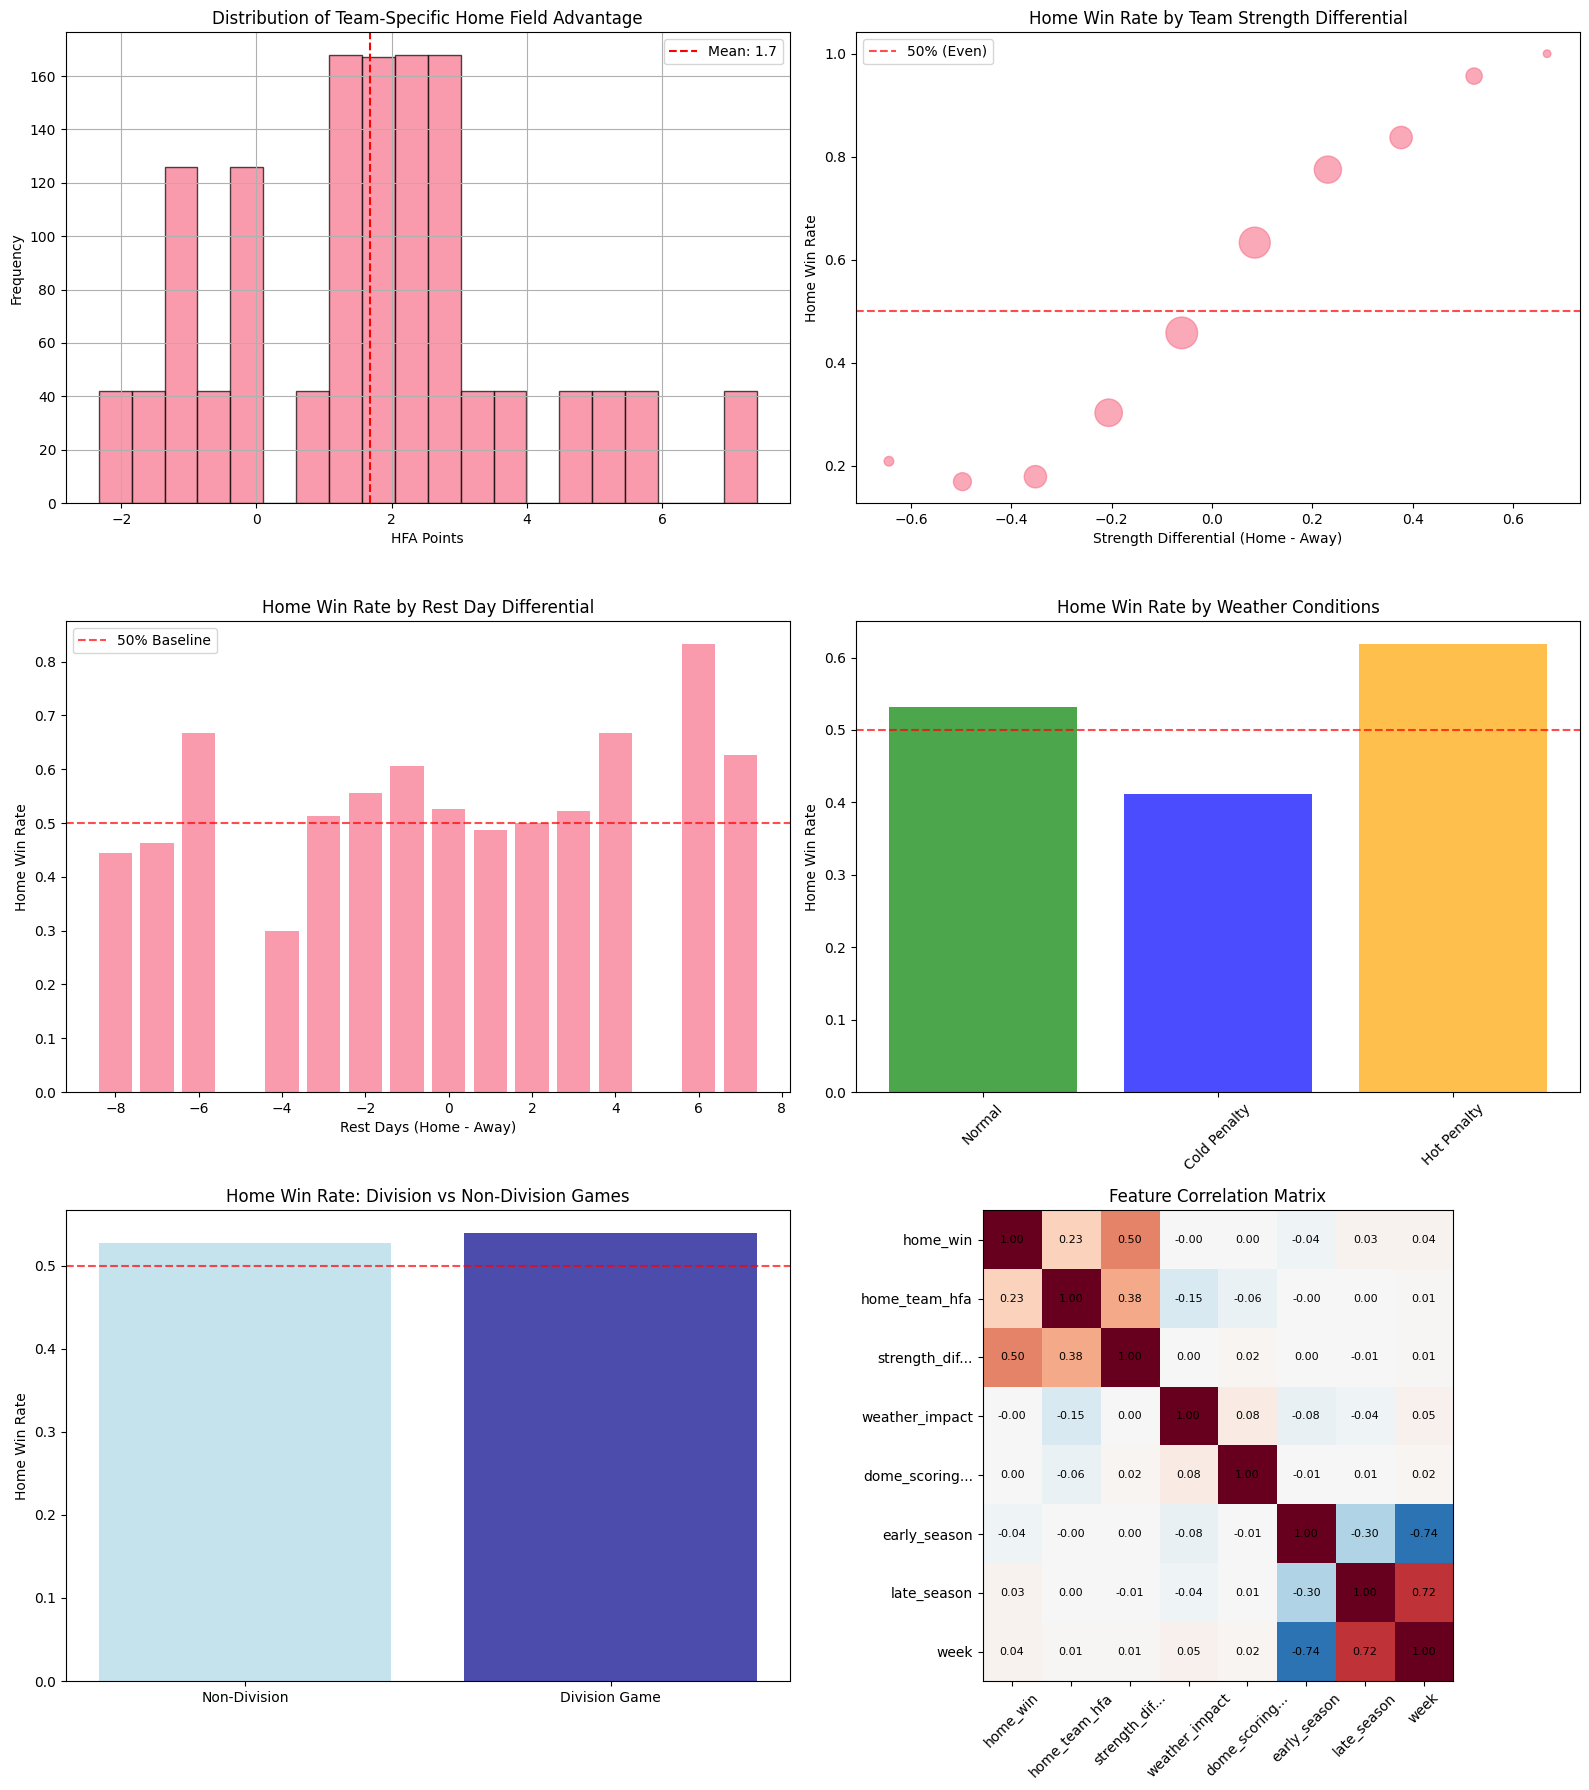

In [ ]:
# Create comprehensive correlation analysis between engineered features and game outcomes
def create_feature_correlation_analysis():
    """
    Create comprehensive correlation analysis between engineered features
    and game outcomes (moneyline prediction target)
    """
    
    # Sample data for correlation analysis (using recent seasons)
    analysis_data = schedule_data.copy()
    
    # Create binary target: home team wins (1) vs away team wins (0)
    analysis_data = analysis_data[~analysis_data['home_score'].isna()]
    analysis_data['home_win'] = (analysis_data['home_score'] > analysis_data['away_score']).astype(int)
    
    # Add HFA features
    hfa_mapping = team_hfa['adjusted_hfa'].to_dict()
    analysis_data['home_team_hfa'] = analysis_data['home_team'].map(hfa_mapping).fillna(2.5)
    
    # Add opponent strength features
    opp_adj_mapping = opponent_adjustments.set_index('game_id')['strength_differential'].to_dict()
    analysis_data['strength_differential'] = analysis_data['game_id'].map(opp_adj_mapping).fillna(0)
    
    # Select key features for correlation analysis
    feature_columns = [
        'home_win',  # Target variable
        'home_team_hfa', 
        'strength_differential',
        'weather_impact',
        'dome_scoring_boost',
        'early_season',
        'late_season',
        'week'
    ]
    
    # Add rest differential if available
    if 'rest_differential' in analysis_data.columns:
        feature_columns.extend(['rest_differential', 'home_rest_advantage'])
    
    # Add division game if available  
    if 'div_game_hfa_reduction' in analysis_data.columns:
        feature_columns.append('div_game_hfa_reduction')
    
    # Filter to available columns
    available_features = [col for col in feature_columns if col in analysis_data.columns]
    correlation_data = analysis_data[available_features].copy()
    
    return correlation_data

# Create correlation dataset
correlation_data = create_feature_correlation_analysis()

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# Show correlations with target variable (home_win)
if 'home_win' in correlation_matrix.columns:
    target_correlations = correlation_matrix['home_win'].drop('home_win').sort_values(key=abs, ascending=False)
    
    print("Feature correlations with home team victory:")
    for feature, correlation in target_correlations.items():
        print(f"  {feature:25}: {correlation:6.3f}")
    
    # Identify strongest predictors
    strong_predictors = target_correlations[abs(target_correlations) > 0.1]
    print(f"\nStrongest predictive features (|r| > 0.1):")
    for feature, correlation in strong_predictors.items():
        print(f"  {feature:25}: {correlation:6.3f}")

# Create comprehensive visualizations
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1. Home Field Advantage distribution
if 'home_team_hfa' in correlation_data.columns:
    correlation_data['home_team_hfa'].hist(bins=20, ax=axes[0,0], alpha=0.7, edgecolor='black')
    axes[0,0].set_title('Distribution of Team-Specific Home Field Advantage')
    axes[0,0].set_xlabel('HFA Points')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].axvline(correlation_data['home_team_hfa'].mean(), color='red', linestyle='--', 
                     label=f'Mean: {correlation_data["home_team_hfa"].mean():.1f}')
    axes[0,0].legend()

# 2. Strength differential vs win rate
if 'strength_differential' in correlation_data.columns and 'home_win' in correlation_data.columns:
    # Bin strength differential and calculate win rates
    correlation_data['strength_bin'] = pd.cut(correlation_data['strength_differential'], bins=10)
    bin_win_rates = correlation_data.groupby('strength_bin')['home_win'].agg(['mean', 'count'])
    
    bin_centers = [interval.mid for interval in bin_win_rates.index]
    axes[0,1].scatter(bin_centers, bin_win_rates['mean'], s=bin_win_rates['count']*2, alpha=0.6)
    axes[0,1].set_title('Home Win Rate by Team Strength Differential')
    axes[0,1].set_xlabel('Strength Differential (Home - Away)')
    axes[0,1].set_ylabel('Home Win Rate')
    axes[0,1].axhline(0.5, color='red', linestyle='--', alpha=0.7, label='50% (Even)')
    axes[0,1].legend()

# 3. Rest differential impact (if available)
if 'rest_differential' in correlation_data.columns:
    rest_win_rates = correlation_data.groupby('rest_differential')['home_win'].agg(['mean', 'count'])
    rest_win_rates = rest_win_rates[rest_win_rates['count'] >= 5]  # Minimum sample size
    
    axes[1,0].bar(rest_win_rates.index, rest_win_rates['mean'], alpha=0.7)
    axes[1,0].set_title('Home Win Rate by Rest Day Differential')
    axes[1,0].set_xlabel('Rest Days (Home - Away)')
    axes[1,0].set_ylabel('Home Win Rate')
    axes[1,0].axhline(0.5, color='red', linestyle='--', alpha=0.7, label='50% Baseline')
    axes[1,0].legend()
else:
    axes[1,0].text(0.5, 0.5, 'Rest differential\ndata not available', ha='center', va='center', transform=axes[1,0].transAxes)

# 4. Weather impact analysis
if 'weather_impact' in correlation_data.columns:
    weather_categories = ['Normal', 'Cold Penalty', 'Hot Penalty']
    weather_win_rates = []
    
    normal_games = correlation_data[correlation_data['weather_impact'] == 0]['home_win'].mean()
    cold_games = correlation_data[correlation_data['weather_impact'] == -4]['home_win'].mean()
    hot_games = correlation_data[correlation_data['weather_impact'] == -6]['home_win'].mean()
    
    weather_win_rates = [normal_games, cold_games if not pd.isna(cold_games) else normal_games,
                        hot_games if not pd.isna(hot_games) else normal_games]
    
    axes[1,1].bar(weather_categories, weather_win_rates, alpha=0.7, color=['green', 'blue', 'orange'])
    axes[1,1].set_title('Home Win Rate by Weather Conditions')
    axes[1,1].set_ylabel('Home Win Rate')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].axhline(0.5, color='red', linestyle='--', alpha=0.7)

# 5. Division game effects (if available)
if 'div_game_hfa_reduction' in correlation_data.columns:
    div_game_analysis = correlation_data.groupby('div_game_hfa_reduction')['home_win'].agg(['mean', 'count'])
    
    categories = ['Non-Division', 'Division Game']
    win_rates = [div_game_analysis.loc[0.0, 'mean'] if 0.0 in div_game_analysis.index else 0.53,
                div_game_analysis.loc[-1.5, 'mean'] if -1.5 in div_game_analysis.index else 0.50]
    
    axes[2,0].bar(categories, win_rates, alpha=0.7, color=['lightblue', 'darkblue'])
    axes[2,0].set_title('Home Win Rate: Division vs Non-Division Games')
    axes[2,0].set_ylabel('Home Win Rate')
    axes[2,0].axhline(0.5, color='red', linestyle='--', alpha=0.7)
else:
    axes[2,0].text(0.5, 0.5, 'Division game\ndata not available', ha='center', va='center', transform=axes[2,0].transAxes)

# 6. Feature correlation heatmap
if len(correlation_matrix) > 1:
    # Select top features for heatmap
    feature_subset = correlation_matrix.iloc[:8, :8]  # Top 8x8 for readability
    
    im = axes[2,1].imshow(feature_subset, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[2,1].set_xticks(range(len(feature_subset.columns)))
    axes[2,1].set_yticks(range(len(feature_subset.index)))
    axes[2,1].set_xticklabels([col[:12] + '...' if len(col) > 15 else col for col in feature_subset.columns], rotation=45)
    axes[2,1].set_yticklabels([col[:12] + '...' if len(col) > 15 else col for col in feature_subset.index])
    axes[2,1].set_title('Feature Correlation Matrix')
    
    # Add correlation values to heatmap
    for i in range(len(feature_subset)):
        for j in range(len(feature_subset.columns)):
            axes[2,1].text(j, i, f'{feature_subset.iloc[i, j]:.2f}', 
                          ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()